In [1]:
import zfit
from zfit import z
import pandas as pd
import root_pandas
from root_pandas import read_root
import ROOT
import matplotlib.pyplot as plt
import tensorflow as tf
#ZFIT_DISABLE_TF_WARNINGS=1
import numpy as np
import mplhep
from hepstats.splot import compute_sweights

/home/belle2/dhettiar/.local/lib/python3.8/site-packages/zfit/__init__.py:63: UserWarning: TensorFlow warnings are by default suppressed by zfit. In order to show them, set the environment variable ZFIT_DISABLE_TF_WARNINGS=0. In order to suppress the TensorFlow warnings AND this warning, set ZFIT_DISABLE_TF_WARNINGS=1.
  warnings.warn(


Welcome to JupyROOT 6.24/06


In [2]:
import ROOT as r
r.gROOT.LoadMacro('/group/belle2/users2022/dhettiar/belle2style/Belle2Style.C') 
r.SetBelle2Style()

# Make nice looking plots
plt.rcParams.update({
          'font.size': 20,
          'figure.figsize': (12, 8),
})


Applying BELLE2 style settings...



In [3]:
# Define columns to read into memory
col = ["Lambdac_M","p_trinaryID","Lambdac_cosTheta_cms","Lambdac_p_cms","Lambdac_flightDistance","p_charge","p_p","p_cosTheta","eventRandom"]
sigcol = ["K1_p","K2_p","K1_binaryID","K2_binaryID"]
ctrcol = ["K_binaryID","K_p","pi_p"]
mccol =["Lambdac_isSignal"]

siginfile = '/group/belle2/users2022/dhettiar/ntuples/MC/lcp/lcp_pkk_s.root'
ctrinfile = '/group/belle2/users2022/dhettiar/ntuples/MC/lcp/lcp_pkpi_s.root'

In [4]:
sigdf = root_pandas.read_root(siginfile, key='lcp_pkk', columns=col+sigcol+mccol, where='Lambdac_p_cms>2.5 && p_trinaryID>0.9 && Lambdac_flightDistance >0 && K1_binaryID>0.2 && K2_binaryID>0.2 && p_p<5.0 && K1_p<4.0 && K2_p<4.0')

In [5]:
ctrdf = root_pandas.read_root(ctrinfile, key='lcp_pkpi', columns=col+ctrcol+mccol, where= 'Lambdac_M > 2.24 && Lambdac_M < 2.34 && Lambdac_p_cms>2.5 && p_trinaryID>0.9 && K_binaryID>0.2 && Lambdac_flightDistance>0 && p_p< 5.0 && pi_p<4.0 && K_p<4.0')

The history saving thread hit an unexpected error (OperationalError('database is locked')).History will not be written to the database.


IOStream.flush timed out


In [6]:
# Standard plot settings
lupper = 2.34
llower = 2.24

In [7]:
# Standard cuts for lambda_c and D^0
lc_cut = str(llower)+' < Lambdac_M < '+str(lupper)

In [8]:
binedges=[-1,0,1]
bin1 = str(binedges[0])+"<=Lambdac_cosTheta_cms<"+str(binedges[1])
bin2 = str(binedges[1])+"<=Lambdac_cosTheta_cms<"+str(binedges[2])
print(bin1)
print(bin2)

-1<=Lambdac_cosTheta_cms<0
0<=Lambdac_cosTheta_cms<1


In [9]:
# Simple plotting function
def plotVar(mydf, var, cuts, nbins=100, myrange=(llower,lupper), mylabel="", log=False):

    if mylabel=="":
        mylabel=var

    ax = plt.subplot()

    # define a numpy array from the given column in the dataframe
    npdata = mydf.query(cuts)[var].to_numpy()

    # create histograms
    ydata, bin_edges = np.histogram(npdata, bins=nbins, range=myrange)
    bin_centers = 0.5*(bin_edges[1:] + bin_edges[:-1])
    ax.errorbar(bin_centers, ydata, yerr = np.sqrt(ydata), fmt='k.', label="MC")

    #nsig = df_mc.query(lcmassrangetight+" and "+cuts+' and Lambdac_isSignal==1')[var].to_numpy().size
    #nbkg = df_mc.query(lcmassrangetight+" and "+cuts+' and not Lambdac_isSignal==1')[var].to_numpy().size
    #print(str(nsig)+" signal and "+str(nbkg)+" background -> ",nsig/(nsig+nbkg))
    
    # set plot features
    plt.ylim(0,None)
    if log==True:
        plt.ylim(0.1,None)
        plt.yscale("log")
    plt.xlim(myrange)
    plt.xlabel(mylabel)
    plt.legend(loc=0)
    plt.show()

In [10]:
# Method to overlay fitted pdfs and data sample
def plot_model(model, mydata, nevents, nbins=100, myrange=(llower,lupper), mylabel="", plot_data=True):

    fig = plt.figure()
    fig.subplots_adjust(hspace=0.4)

    from matplotlib import gridspec
    gs = gridspec.GridSpec(2, 1, height_ratios=[5, 1]) 
    ax0 = plt.subplot(gs[0])
    ax1 = plt.subplot(gs[1])
    lower, upper = mydata.data_range.limit1d

    x = tf.linspace(lower, upper, num=nbins)  # np.linspace also works
    for mod, frac in zip(model.pdfs, model.params.values()):
        y = mod.pdf(x) * nevents / nbins * mydata.data_range.area()
        y *= frac
        ax0.plot(x, y)
    data_plot = zfit.run(z.unstack_x(mydata))  # we could also use the `to_pandas` method
    y = model.pdf(x) * nevents / nbins * mydata.data_range.area()
    ax0.plot(x, y)

    counts, bin_edges = np.histogram(data_plot, bins=nbins, range=myrange)
    bin_centers = (bin_edges[:-1] + bin_edges[1:])/2.
    yerrs = counts**0.5
    ax0.errorbar(bin_centers, counts, yerr=yerrs, fmt='k.', linestyle='')
    ax0.set_xlabel(mylabel)
    ax0.set_xlim(myrange)
    ax0.set_ylim(0,None)

    X = np.ma.masked_equal(yerrs,0)
    ypull = (y-counts)/X
    ax1.errorbar(bin_centers, ypull, yerr=ypull*[0], fmt='k.', linestyle='')
    ax1.set_xlim(myrange)
    ax1.set_ylim(-5,5)

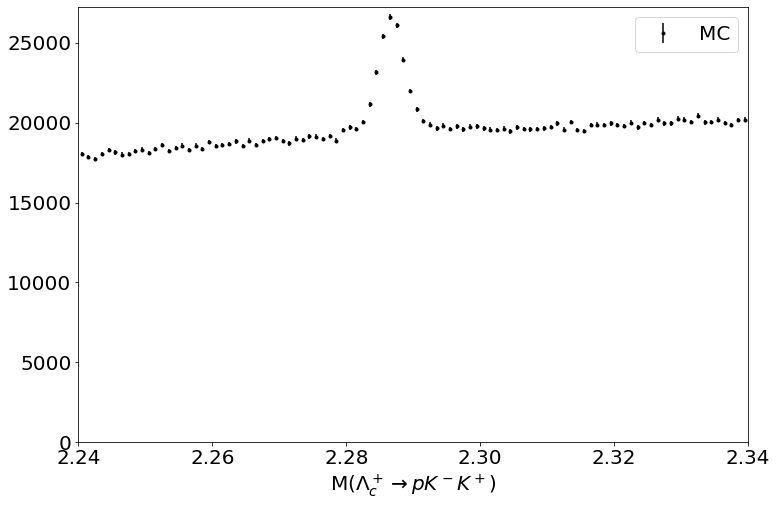

In [11]:
plotVar(sigdf,"Lambdac_M",lc_cut,mylabel=r'M($\Lambda_c^+\rightarrow p K^- K^+$)')

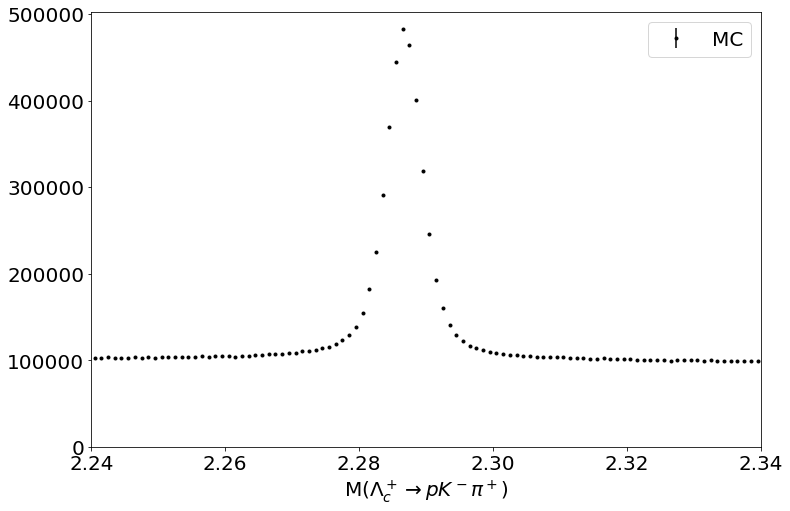

In [12]:
plotVar(ctrdf,"Lambdac_M",lc_cut,mylabel=r'M($\Lambda_c^+\rightarrow p K^- \pi^+$)')

# Data frames for reweighting

In [13]:
# Stack plot of signal channel
np_pkk_M_sw = sigdf.query(lc_cut)['Lambdac_M'].to_numpy()    
np_pkk_p_sw = sigdf.query(lc_cut)['p_p'].to_numpy()       
np_pkk_cosTheta_sw = sigdf.query(lc_cut)['p_cosTheta'].to_numpy()     

In [14]:
# Stack plot of control channel
np_pkpi_M_sw = ctrdf.query(lc_cut)['Lambdac_M'].to_numpy()
np_pkpi_p_sw = ctrdf.query(lc_cut)['p_p'].to_numpy()      
np_pkpi_cosTheta_sw = ctrdf.query(lc_cut)['p_cosTheta'].to_numpy()  

# ZFit for $\Lambda_c^+$

In [15]:
# Define default parameters for zfit
lcrange = (llower,lupper)
lcobs = zfit.Space('Lambdac_M', lcrange)
issignal = 'Lambdac_isSignal==1'

# Get the signal and background for reference
signal = sigdf.query(lc_cut + ' and Lambdac_isSignal==1').Lambdac_M.to_numpy()
bkg = sigdf.query(lc_cut + ' and Lambdac_isSignal!=1').Lambdac_M.to_numpy()
print('signal: ' + str(len(signal)))
print('bkg: ' + str(len(bkg)))

signal: 41206
bkg: 1922921


In [16]:
# Signal fit parameters
mu = zfit.Parameter("mu", 2.289, 2.27, 2.3)
s1 = zfit.param.Parameter("s1", 0.020, 0.0001, 0.04)
s2 = zfit.param.Parameter("s2", 0.005, 0.0001, 0.04)
fg1 = zfit.param.Parameter("fg1", 0.20, 0., 1.)
a1 = zfit.Parameter("a1", 0.01, -1e6, 1e6)

# define PDFs
gaus1 = zfit.pdf.Gauss(obs=lcobs, mu=mu, sigma=s1)
gaus2 = zfit.pdf.Gauss(obs=lcobs, mu=mu, sigma=s2)
gaus = zfit.pdf.SumPDF(pdfs=[gaus1,gaus2], fracs=[fg1])

poly = zfit.pdf.Chebyshev(obs=lcobs, coeffs=[a1])
sig_yield = zfit.Parameter('sig_yield', 10000, 0, 1e9, step_size=1)
bkg_yield = zfit.Parameter('bkg_yield', 500000, 0, 1e9, step_size=1)

sig_ext = gaus.create_extended(sig_yield)
bkg_ext = poly.create_extended(bkg_yield)

pdf_ext = zfit.pdf.SumPDF(pdfs=[sig_ext,bkg_ext])

# Signal Fit for $\Lambda_c^+\$

In [17]:
# Fill an array with the data to be fit
data_np = sigdf.query(lc_cut+' and '+issignal).Lambdac_M.to_numpy()
data = zfit.data.Data.from_numpy(obs=lcobs, array=data_np)
data.set_data_range(lcrange) 
data_size = data.n_events

In [18]:
# Fix background to zero
a1.floating = False
bkg_yield.set_value(0)
bkg_yield.floating = False

# Define loss function
nll_simultaneous = zfit.loss.ExtendedUnbinnedNLL(model=pdf_ext,data=data)
minimizer = zfit.minimize.Minuit()
result = minimizer.minimize(nll_simultaneous)  
print(result)

FitResult of
<ExtendedUnbinnedNLL model=[<zfit.<class 'zfit.models.functor.SumPDF'>  params=[Composed_autoparam_5, Composed_autoparam_6]] data=[<zfit.core.data.Data object at 0x7f0b1505f8b0>] constraints=[]> 
with
<Minuit Minuit tol=0.001>

╒═════════╤═════════════╤══════════════════╤═════════╤══════════════════════════════════╕
│  valid  │  converged  │  param at limit  │   edm   │   approx. fmin (full | internal) │
╞═════════╪═════════════╪══════════════════╪═════════╪══════════════════════════════════╡
│  True   │    True     │      False       │ 0.00015 │           -179035.86 | -35649.11 │
╘═════════╧═════════════╧══════════════════╧═════════╧══════════════════════════════════╛

Parameters
name         value  (rounded)    at limit
---------  ------------------  ----------
sig_yield             41206.6       False
fg1                  0.127601       False
mu                    2.28674       False
s1                  0.0119863       False
s2                 0.00204969       False


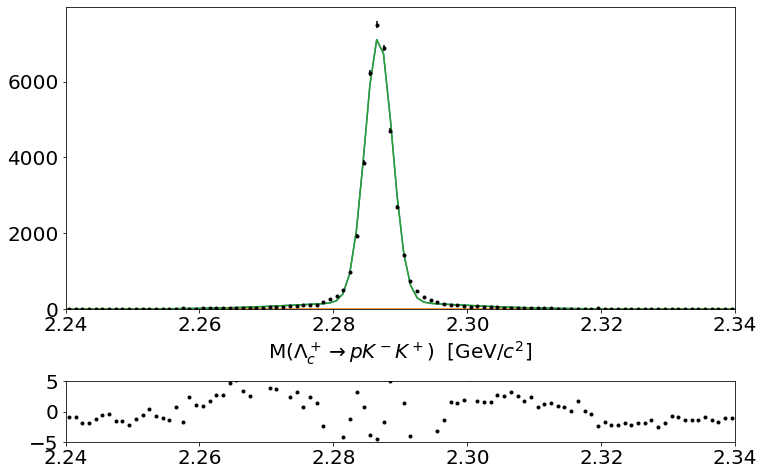

In [19]:
plot_model(model=pdf_ext, mydata=data, nevents=int(data_size), mylabel=r'M($\Lambda_c^+\rightarrow p K^- K^+$)  [GeV/$c^{2}$]')

In [20]:
# Save the signal parameters
lcsigmean=result.params[mu].get('value')
lcsigsigma1=result.params[s1].get('value')
lcsigsigma2=result.params[s2].get('value')
lcsigfg1=result.params[fg1].get('value')

print('lcsigmean =',r'%.5f' %lcsigmean)
print('lcsigsigma1 =',r'%.5f' %lcsigsigma1)
print('lcsigsigma2 =',r'%.5f' %lcsigsigma2)
print('lcsigfg1 =',r'%.5f' %lcsigfg1)

lcsigmean = 2.28674
lcsigsigma1 = 0.01199
lcsigsigma2 = 0.00205
lcsigfg1 = 0.12760


# Intergrated Fits 

## $\Lambda_c^+\rightarrow p K^- K^+\$ - signal channel intergrated fit

In [21]:
# Fill an array with the data to be fit
data_np = sigdf.query(lc_cut).Lambdac_M.to_numpy()
data = zfit.data.Data.from_numpy(obs=lcobs, array=data_np)
data.set_data_range(lcrange) 
data_size = data.n_events

In [22]:
# Float background
a1.floating = True
bkg_yield.set_value(500000)
bkg_yield.floating = True

# Fix signal shape
s1.floating = False
s1.set_value(lcsigsigma1)
s2.floating = False
s2.set_value(lcsigsigma2)
fg1.floating = False
fg1.set_value(lcsigfg1)

# Define loss function
nll_simultaneous = zfit.loss.ExtendedUnbinnedNLL(model=pdf_ext,data=data)
minimizer = zfit.minimize.Minuit()
result = minimizer.minimize(nll_simultaneous)  
print(result)

FitResult of
<ExtendedUnbinnedNLL model=[<zfit.<class 'zfit.models.functor.SumPDF'>  params=[Composed_autoparam_5, Composed_autoparam_6]] data=[<zfit.core.data.Data object at 0x7f0ad4ac03a0>] constraints=[]> 
with
<Minuit Minuit tol=0.001>

╒═════════╤═════════════╤══════════════════╤═════════╤══════════════════════════════════╕
│  valid  │  converged  │  param at limit  │   edm   │   approx. fmin (full | internal) │
╞═════════╪═════════════╪══════════════════╪═════════╪══════════════════════════════════╡
│  True   │    True     │      False       │ 0.00076 │           -4527833.24 | -1118076 │
╘═════════╧═════════════╧══════════════════╧═════════╧══════════════════════════════════╛

Parameters
name         value  (rounded)    at limit
---------  ------------------  ----------
sig_yield             42447.9       False
bkg_yield         1.92172e+06       False
mu                     2.2867       False
a1                  0.0581463       False


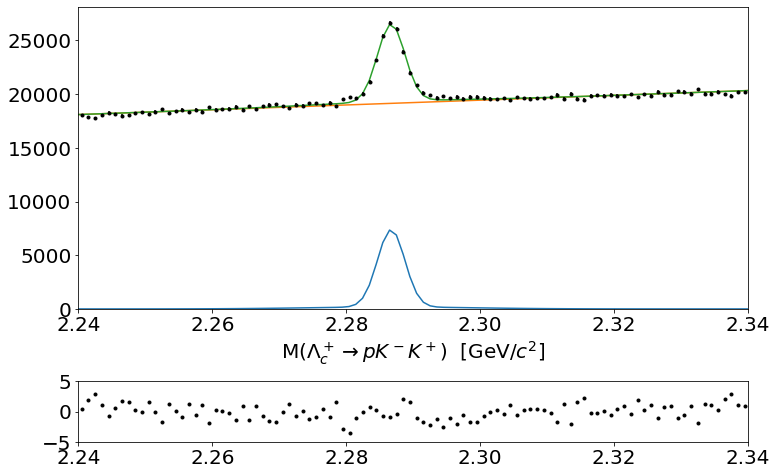

In [23]:
plot_model(model=pdf_ext, mydata=data, nevents=int(data_size), mylabel=r'M($\Lambda_c^+\rightarrow p K^- K^+$)  [GeV/$c^{2}$]')

In [24]:
pkkweights = compute_sweights(pdf_ext, data)

## $\Lambda_c^+ \rightarrow pK^-\pi^+$ - control channel integrated fit

In [25]:
# Fill an array with the data to be fit
data_np = ctrdf.query(lc_cut).Lambdac_M.to_numpy()
data = zfit.data.Data.from_numpy(obs=lcobs, array=data_np)
data.set_data_range(lcrange) 
data_size = data.n_events

In [26]:
# Float background
a1.floating = True

sig_yield.set_value(700000)
sig_yield.floating = True
bkg_yield.set_value(2500000)
bkg_yield.floating = True

# Fix signal shape
s1.floating = True
s1.set_value(lcsigsigma1)
s2.floating = True
s2.set_value(lcsigsigma2)
fg1.floating = True
fg1.set_value(lcsigfg1)

# Define loss function
nll_simultaneous = zfit.loss.ExtendedUnbinnedNLL(model=pdf_ext,data=data)
minimizer = zfit.minimize.Minuit()
result = minimizer.minimize(nll_simultaneous)  
print(result)

FitResult of
<ExtendedUnbinnedNLL model=[<zfit.<class 'zfit.models.functor.SumPDF'>  params=[Composed_autoparam_5, Composed_autoparam_6]] data=[<zfit.core.data.Data object at 0x7f0ad49a5880>] constraints=[]> 
with
<Minuit Minuit tol=0.001>

╒═════════╤═════════════╤══════════════════╤════════╤══════════════════════════════════╕
│  valid  │  converged  │  param at limit  │  edm   │   approx. fmin (full | internal) │
╞═════════╪═════════════╪══════════════════╪════════╪══════════════════════════════════╡
│  True   │    True     │      False       │ 0.0012 │          -31936743.88 | -8753534 │
╘═════════╧═════════════╧══════════════════╧════════╧══════════════════════════════════╛

Parameters
name         value  (rounded)    at limit
---------  ------------------  ----------
sig_yield         2.91208e+06       False
bkg_yield         1.02657e+07       False
fg1                  0.279095       False
mu                    2.28668       False
s1                 0.00721759       False
s2      

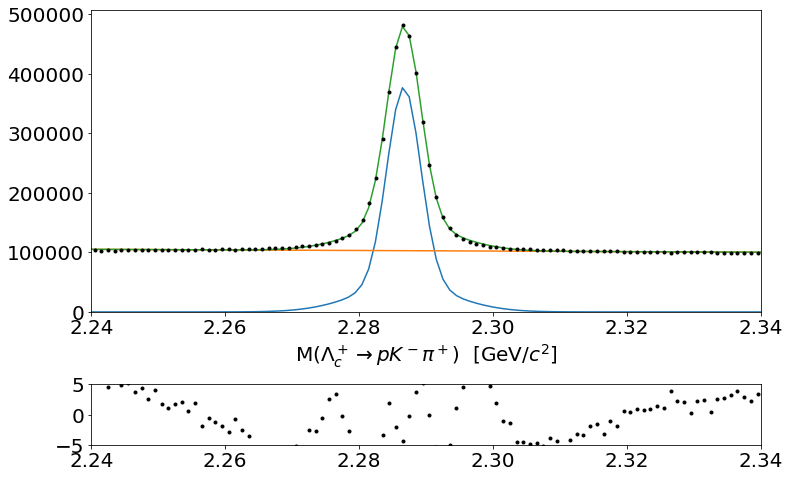

In [27]:
plot_model(model=pdf_ext, mydata=data, myrange=lcrange, nevents=int(data_size), mylabel=r'M($\Lambda_c^+\rightarrow p K^- \pi^+$)  [GeV/$c^{2}$]')

In [28]:
# Save the control parameters
lcctrmean=mu
lcctrsigma1=s1
lcctrsigma2=s2
lcctrfg1=fg1

mu.floating = False
s1.floating = False
s2.floating = False
fg1.floating = False

print('lcctrmean =',r'%.5f' %lcctrmean)
print('mu =',r'%.5f' %lcctrmean)
print('lcctrsigma1 =',r'%.5f' %lcctrsigma1)
print('lcctrsigma2 =',r'%.5f' %lcctrsigma2)
print('lcctrfg1 =',r'%.5f' %lcctrfg1)

lcctrmean = 2.28668
mu = 2.28668
lcctrsigma1 = 0.00722
lcctrsigma2 = 0.00252
lcctrfg1 = 0.27909


In [29]:
pkpiweights = compute_sweights(pdf_ext, data)

# Reweighting

In [30]:
nbins = 25
p_range = (0, 5.0)
cosTheta_range = (-1,1)

In [31]:
pkpiscale = pkkweights[sig_yield].sum()/pkpiweights[sig_yield].sum()
print(pkpiscale)

0.014576479077083261


In [32]:
# Reweighting for proton momentum
pkk_counts_per_bin_p = np.histogram(np_pkk_p_sw, bins=nbins, weights=pkkweights[sig_yield], range=p_range)
pkpi_counts_per_bin_p = np.histogram(np_pkpi_p_sw, bins=nbins, weights=[pkpiscale]*pkpiweights[sig_yield], range=p_range)

# Calculate the event ratio for each bin
pkk_counts_per_bin_p = pkk_counts_per_bin_p[0]  # Extract the counts from the tuple
pkpi_counts_per_bin_p = pkpi_counts_per_bin_p[0]
event_ratio_p = pkk_counts_per_bin_p / pkpi_counts_per_bin_p

# Calculate the bin edges
bin_edges_p = np.linspace(p_range[0], p_range[1], nbins + 1)

# Assign each event to a bin.
event_bins_p = np.digitize(np_pkpi_p_sw, bin_edges_p)
event_bins_p -= 1

ctrdf_pweighted = ctrdf.query(lc_cut)

# Create an empty list to store weighted events
pkpi_pweights = []

for event in range(len(ctrdf_pweighted)):
    event_bin_index_p = event_bins_p[event]
    
    # Ensure the bin indices are within the valid range
    if event_bin_index_p >= nbins: 
        weight = 1
    
    else:
        # Calculate weight from the 2D event_ratio for both pi_p and K_p
        pweight = event_ratio_p[event_bin_index_p] 

    pkpi_pweights.append(pweight)    

In [33]:
# Reweighting for the proton costheta
pkk_counts_per_bin_cosTheta = np.histogram(np_pkk_cosTheta_sw, bins=nbins, weights=pkkweights[sig_yield], range=cosTheta_range)
pkpi_counts_per_bin_cosTheta = np.histogram(np_pkpi_cosTheta_sw, bins=nbins, weights=pkpi_pweights*pkpiweights[sig_yield], range=cosTheta_range)

# Calculate the event ratio for each bin
pkk_counts_per_bin_cosTheta = pkk_counts_per_bin_cosTheta[0]  # Extract the counts from the tuple
pkpi_counts_per_bin_cosTheta = pkpi_counts_per_bin_cosTheta[0]
event_ratio_cosTheta = pkk_counts_per_bin_cosTheta / pkpi_counts_per_bin_cosTheta

# Calculate the bin edges
bin_edges_cosTheta = np.linspace(cosTheta_range[0], cosTheta_range[1], nbins + 1)

# I want to scale up and compair with "np_xic_sig_p_sw"
event_bins_cosTheta = np.digitize(np_pkpi_cosTheta_sw, bin_edges_cosTheta)
event_bins_cosTheta -= 1

ctrdf_cweighted = ctrdf.query(lc_cut)

# Create an empty list to store weighted events
pkpi_cweights = []

for event in range(len(ctrdf_cweighted)):
    event_bin_index_cosTheta = event_bins_cosTheta[event]
    
    # Ensure the bin indices are within the valid range
    if event_bin_index_cosTheta >= nbins: 
        weight = 1
    
    else:
        # Calculate weight from the 2D event_ratio for both pi_p and K_p
        cweight = event_ratio_cosTheta[event_bin_index_cosTheta] 

    pkpi_cweights.append(cweight)    

In [34]:
reWeights = [a*b for a,b in zip(pkpi_pweights,pkpi_cweights)]

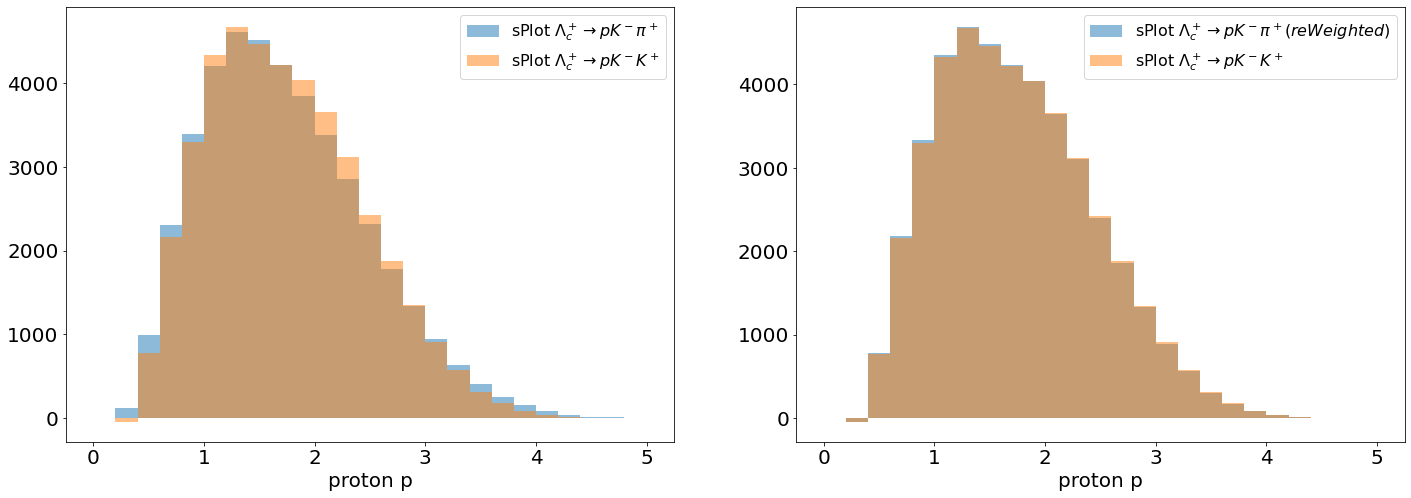

In [35]:
# Plotting sweights for momentum density = True
fig, axs = plt.subplots(1, 2, figsize=(24, 8))
nbins = 25

axs[0].hist(np_pkpi_p_sw, bins=nbins, range=p_range, weights=pkpiscale*pkpiweights[sig_yield], label=r"sPlot $\Lambda_c^+\rightarrow p K^- \pi^+$", alpha=.5, density=False)
axs[0].hist(np_pkk_p_sw, bins=nbins, range=p_range, weights=pkkweights[sig_yield], label=r"sPlot $\Lambda_c^+\rightarrow p K^- K^+$", alpha=.5, density=False)
axs[0].set_xlabel(r"proton p")
axs[0].legend(fontsize=16)

axs[1].hist(np_pkpi_p_sw, bins=nbins, range=p_range, weights=reWeights*pkpiweights[sig_yield], label=r"sPlot $\Lambda_c^+\rightarrow p K^- \pi^+ (reWeighted)$", alpha=.5, density=False)
axs[1].hist(np_pkk_p_sw, bins=nbins, range=p_range, weights=pkkweights[sig_yield], label=r"sPlot $\Lambda_c^+\rightarrow p K^- K^+$", alpha=.5, density=False)
axs[1].set_xlabel(r"proton p")
axs[1].legend(fontsize=16)

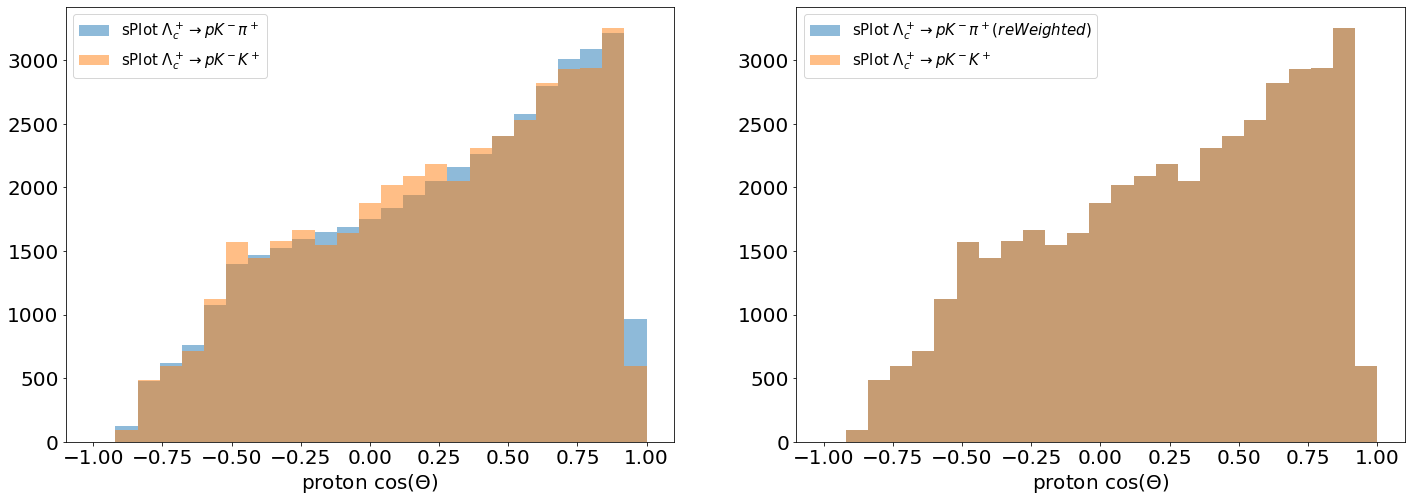

In [36]:
# Plotting sweights for momentum density = True
fig, axs = plt.subplots(1, 2, figsize=(24, 8))
nbins = 25

axs[0].hist(np_pkpi_cosTheta_sw, bins=nbins, range=cosTheta_range, weights=pkpiscale*pkpiweights[sig_yield], label=r"sPlot $\Lambda_c^+\rightarrow p K^- \pi^+$", alpha=.5, density=False)
axs[0].hist(np_pkk_cosTheta_sw, bins=nbins, range=cosTheta_range, weights=pkkweights[sig_yield], label=r"sPlot $\Lambda_c^+\rightarrow p K^- K^+$", alpha=.5, density=False)
axs[0].set_xlabel(r"proton cos($\Theta$)")
axs[0].legend(fontsize=15)

axs[1].hist(np_pkpi_cosTheta_sw, bins=nbins, range=cosTheta_range, weights=reWeights*pkpiweights[sig_yield], label=r"sPlot $\Lambda_c^+\rightarrow p K^- \pi^+ (reWeighted)$", alpha=.5, density=False)
axs[1].hist(np_pkk_cosTheta_sw, bins=nbins, range=cosTheta_range, weights=pkkweights[sig_yield], label=r"sPlot $\Lambda_c^+\rightarrow p K^- K^+$", alpha=.5, density=False)
axs[1].set_xlabel(r"proton cos($\Theta$)")
axs[1].legend(fontsize=15)

In [37]:
ctrdf_weighted = ctrdf.query(lc_cut)
ctrdf_weighted['reWeights'] = reWeights

In [38]:
# Specify the directory to write the root file
path = "/group/belle2/users2022/dhettiar/ntuples/MC/lcp/lcp_pkpi_pkk_weighted.root"

In [39]:
root_pandas.to_root(ctrdf_weighted, path, key='lcp_pkpi', mode='w')